# 2016-10-07: Regularized Logistic Regression
In this lab, we will appply logistic regression to the Endometrium vs. Uterus cancer data.

Let us start by setting up our environment, loading the data, and setting up our cross-validation.

In [1]:
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data as usual (here the code for Python 2.7)
X = np.loadtxt('data/small_Endometrium_Uterus.csv',  delimiter=',', skiprows=1, usecols=range(1, 3001))
y = np.loadtxt('data/small_Endometrium_Uterus.csv', delimiter=',', skiprows=1, usecols=[3001], 
               converters={3001: lambda s: 0 if s=='Endometrium' else 1}, dtype='int')


In [4]:
# Set up a stratified 10-fold cross-validation
from sklearn.model_selection import StratifiedKFold
folds = cross_validation.StratifiedKFold(y, 10, shuffle=True)

In [5]:
# Create a function that does cross-validation and scales the features on each training set.
from sklearn import preprocessing
def cross_validate_with_scaling(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions. 
    Use a scaler to scale the features to mean 0, standard deviation 1.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape) # vector of 0 in which to store the predictions
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        #print Xtr.shape, ytr.shape, Xte.shape

        # Scale data
        scaler = preprocessing.StandardScaler() # create scaler
        Xtr = scaler.fit_transform(Xtr) # fit the scaler to the training data and transform training data
        Xte = scaler.transform(Xte) # transform test data

        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Predict probabilities (of belonging to +1 class) on test data
        yte_pred = classifier.predict_proba(Xte) # two-dimensional array
        # Identify the index, in yte_pred, of the positive class (y=1)
        # index_of_class_1 = np.nonzero(classifier.classes_ == 1)[0][0] 
        #index_of_class_1 = 1 - ytr[0] # 0 if the first sample is positive, 1 otherwise
        pred[te] = yte_pred[:, 1]                
    return pred

## 1. L1-Regularized Logistic Regression 

Let us start with default parameters.

In [6]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(penalty='l1')

**Question** Compute the cross-validated predictions of the l1-regularized logistic regression with default parameters on our data.

In [7]:
my_predictions = cross_validate_with_scaling(X, y, clf, folds)
print my_predictions

[  6.99651513e-01   2.01427727e-02   4.19543694e-01   7.74168877e-02
   6.97355241e-01   2.62062750e-01   9.97256478e-01   4.47313386e-01
   5.75755747e-01   6.23099328e-01   9.85955694e-01   9.97839038e-01
   9.95562684e-01   9.80492146e-01   8.08341679e-01   9.93045071e-01
   9.61736943e-01   9.55552071e-01   9.87543152e-01   3.23883562e-01
   8.77563147e-01   6.65676628e-01   4.22743897e-01   6.81983466e-01
   9.28375296e-01   9.96625258e-01   9.92490614e-01   8.79749217e-01
   9.54576776e-01   7.66168166e-01   9.92491585e-01   9.94901636e-01
   2.04902526e-01   4.77264028e-01   9.21028083e-01   9.97179601e-01
   9.96604644e-01   9.36388839e-01   3.68322129e-01   5.87983672e-02
   9.53234907e-01   8.84431712e-01   7.77721256e-01   1.25517250e-01
   9.02707805e-01   9.99498311e-01   5.62490650e-01   9.14319775e-01
   7.54153238e-01   9.88965371e-01   9.92387040e-01   8.88825914e-01
   6.65239956e-01   9.89730277e-01   9.13949474e-01   1.15374421e-01
   7.19624364e-01   3.33389402e-02

**Question** Plot the corresponding ROC curve, and compare it to that obtained for non-regularized logistic regression.

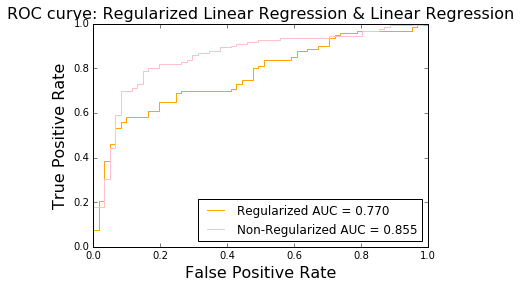

In [9]:
# ROC curve2
from sklearn import metrics

clf2 = linear_model.LogisticRegression(C=1e6)
my_predictions2 = cross_validate_with_scaling(X, y, clf2, folds)

fpr, tpr, thresholds = metrics.roc_curve(y, my_predictions, pos_label=1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y, my_predictions2, pos_label = 1)
# Area under the ROC curve
auc = metrics.auc(fpr, tpr)
auc2 = metrics.auc(fpr2, tpr2)

# Plot the ROC curve
plt.plot(fpr, tpr, '-', color='orange', label='Regularized AUC = %0.3f' % auc)
plt.plot(fpr2, tpr2, '-', color='pink', label='Non-Regularized AUC = %0.3f' % auc2)


plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Regularized Linear Regression & Linear Regression', fontsize=16)
plt.legend(loc="lower right")


### Setting the C parameter
What does the C parameter correspond to? See the documentation at http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression for help.

Scikit-learn makes it really easy to use a nested cross-validation to choose a good value for C among a grid of several choices.

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[1e-3, 1e-2, 1e-1, 1., 1e2, 1e3]}
clf = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l1'), param_grid)
clf.fit(X, y)
#print clf.get_params()

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

**Question** What criterion is used to chose the optimal C? See the documentation at http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV.  Try changing this criterion http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter 

In [14]:
clf2 = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l2'), param_grid)
clf2.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

**Question** Compute the cross-validated predictions of the l1-regularized logistic regression with optimized C parameter on our data.

In [15]:
my_predictionsg = cross_validate_with_scaling(X, y, clf, folds)
print my_predictionsg

[  6.45172909e-01   2.35575316e-03   4.21956927e-01   2.61241529e-01
   4.83366407e-01   8.04695295e-01   9.99503597e-01   9.61097611e-01
   5.91417937e-01   6.93154299e-01   9.99899954e-01   7.56823700e-01
   8.92275684e-01   8.24833783e-01   6.75811165e-01   8.91783760e-01
   9.94641682e-01   9.90081082e-01   7.05259009e-01   4.40177831e-01
   7.46084518e-01   6.23351960e-01   3.86712633e-01   6.47166028e-01
   9.94947164e-01   8.97155165e-01   9.99973293e-01   7.21878103e-01
   9.22014879e-01   9.40660405e-01   8.33374492e-01   9.99891091e-01
   1.97396178e-01   5.99441897e-01   7.10052041e-01   9.97135722e-01
   8.10490863e-01   6.64647459e-01   3.63350894e-01   1.66313381e-03
   9.53709668e-01   3.94624061e-01   9.99970238e-01   3.27469668e-01
   9.31489285e-01   8.09074235e-01   9.97223070e-01   6.92336261e-01
   6.48483031e-01   9.88192347e-01   7.98781344e-01   9.98041099e-01
   9.73801523e-01   7.23104475e-01   9.11565878e-01   6.06338691e-01
   7.04838587e-01   2.03430095e-01

GridSearchCV also uses the optimal parameter(s) it detected to fit a model to its entire training data again, generating a "best model" that is accessible via the `best_estimator_` attribute.

In our case, because we called GridSearchCV from inside a cross-validation loop, `clf.best_estimator_` is the "best model" *on the last training fold*.

In [17]:
print clf.best_params_

{'C': 100.0}


**Question** Plot the corresponding ROC curve, and compare to that obtained for 
* non-regularized logistic regression.
* l1-regularized logistic regression with default C parameter.

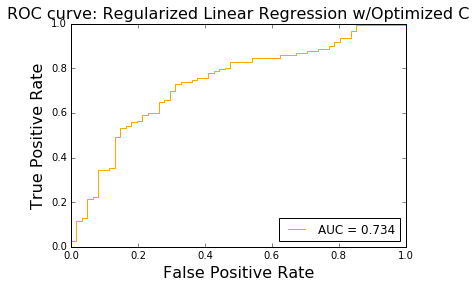

In [18]:

fpr3, tpr3, thresholds3 = metrics.roc_curve(y, my_predictionsg, pos_label=1)


# Area under the ROC curve
auc3 = metrics.auc(fpr3, tpr3)

# Plot the ROC curve
plt.plot(fpr3, tpr3, '-', color='orange', label='AUC = %0.3f' % auc3)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Regularized Linear Regression w/Optimized C', fontsize=16)
plt.legend(loc="lower right")

### Regression weights
Remember the goal of l1-regularization is to build sparse models. 

(0, 3000)

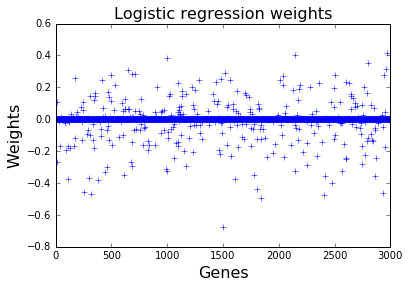

In [19]:
# This code plots the regression weights of the classifier 'clf'
plt.plot(range(len(clf.best_estimator_.coef_[0])), clf.best_estimator_.coef_[0], 
         color='blue', marker='+', linestyle='')
plt.xlabel('Genes', fontsize=16)
plt.ylabel('Weights', fontsize=16)
plt.title('Logistic regression weights', fontsize=16)
plt.xlim([0, X.shape[1]])

**Question** Compare the regression weights obtained with and without l1-regularization, in two side-by-side plots.

In [21]:
clflr = linear_model.LogisticRegression(C=1e6)
cross_validate_with_scaling(X, y, clflr, folds)

array([  1.61771467e-01,   8.68968286e-07,   1.37394853e-04,
         3.78890030e-03,   2.37974157e-02,   8.37344742e-04,
         5.76762830e-01,   9.50867515e-01,   9.77389402e-01,
         9.98829810e-01,   9.99992624e-01,   9.99942372e-01,
         9.96999111e-01,   9.99951484e-01,   9.62406608e-01,
         9.99999594e-01,   9.99995349e-01,   9.62424827e-01,
         9.95338988e-01,   1.26813776e-07,   1.34698754e-03,
         5.32594552e-04,   2.39094967e-01,   5.53455917e-04,
         9.99980770e-01,   9.99996155e-01,   9.99998185e-01,
         9.45224075e-01,   9.99410475e-01,   4.20843313e-01,
         9.99997923e-01,   9.99999636e-01,   5.44487216e-01,
         8.14700941e-01,   9.53816189e-01,   9.99999964e-01,
         9.71137240e-01,   9.90331852e-01,   2.26404145e-02,
         2.22652799e-09,   5.49109963e-03,   7.13804078e-04,
         9.96599046e-01,   5.08767193e-06,   6.96641417e-01,
         9.99999988e-01,   5.78042999e-01,   9.98359847e-01,
         9.98397818e-01,

In [24]:
shape(clflr.coef_[0])

(3000,)

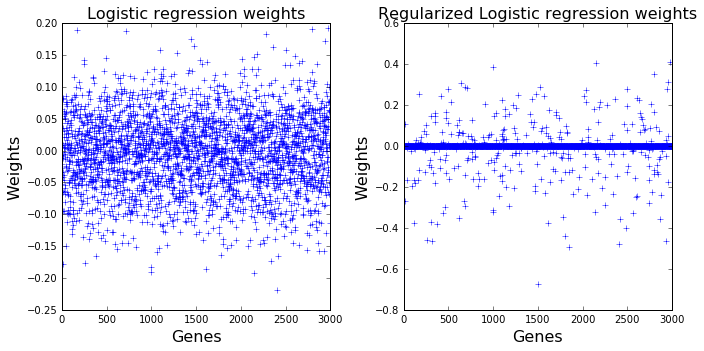

In [25]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121) # use a 1x2 subplot grid; ax will refer to the 1st subplot


#my_predictions2 = cross_validate_with_scaling(X, y, clf2, folds)
number_of_weights = len(clflr.coef_[0]) #range(len(clf.best_estimator_.coef_[0])) #TODO
logreg_weights = clflr.coef_[0] #TODO

ax.plot(range(number_of_weights), logreg_weights, 
         color='blue', marker='+', linestyle='')
ax.set_xlabel('Genes', fontsize=16)
ax.set_ylabel('Weights', fontsize=16)
ax.set_title('Logistic regression weights', fontsize=16)
ax.set_xlim([0, X.shape[1]])

ax = fig.add_subplot(122) # use a 1x2 subplot grid; ax will refer to the 2nd subplot

l1_logreg_weights = clf.best_estimator_.coef_[0]#TODO

ax.plot(range(number_of_weights), l1_logreg_weights, 
         color='blue', marker='+', linestyle='')
ax.set_xlabel('Genes', fontsize=16)
ax.set_ylabel('Weights', fontsize=16)
ax.set_title('Regularized Logistic regression weights', fontsize=16)
ax.set_xlim([0, X.shape[1]])
plt.tight_layout()

## 2. L2-regularized logistic regression

**Question** What is the role of l2 regularization?

In [26]:
clf = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l2'), param_grid)

**Question** Compute the cross-validated predictions of an l2-regularized logistic regression with optimized C parameters on our data.

In [27]:
my_predl2 = cross_validate_with_scaling(X, y, clf, folds)

**Question** Plot the corresponding ROC curve, and compare to that obtained for
* non-regularized logistic regression
* l1-regularized logistic regression (with optimized C parameter)

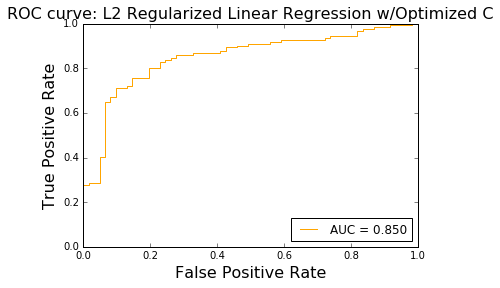

In [28]:
fpr4, tpr4, thresholds4 = metrics.roc_curve(y, my_predl2, pos_label=1)


# Area under the ROC curve
auc4 = metrics.auc(fpr4, tpr4)

# Plot the ROC curve
plt.plot(fpr4, tpr4, '-', color='orange', label='AUC = %0.3f' % auc4)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: L2 Regularized Linear Regression w/Optimized C', fontsize=16)
plt.legend(loc="lower right")

**Question** Compare the regression weights obtained with l2-regularization to those obtained 
* with l1-regularization.
* with no regularization.
Do your observations match your expectations?

(0, 3000)

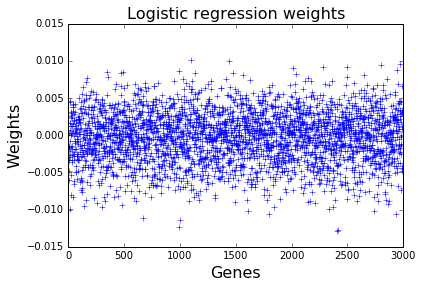

In [29]:
# This code plots the regression weights of the classifier 'clf'
plt.plot(range(len(clf.best_estimator_.coef_[0])), clf.best_estimator_.coef_[0], 
         color='blue', marker='+', linestyle='')
plt.xlabel('Genes', fontsize=16)
plt.ylabel('Weights', fontsize=16)
plt.title('Logistic regression weights', fontsize=16)
plt.xlim([0, X.shape[1]])

## 3. Kaggle challenge
* Cross-validate an l1-regularized linear regression (lasso) on your data, using the folds you previously set up for non-regularized linear regression. Do you obtain better performance? Can you draw some conclusions regarding the usefulness of the different features for the prediction task?
* Cross-validate an l2-regularized linear regression (ridge regression) on your data, using the folds you previously set up for non-regularized linear regression. Do you obtain better performance?
* Submit predictions to the leaderboard for both those models. Do the results on the leaderboard data match your expectations?